In [33]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright 2021-  QuOCS Team
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [34]:
import matplotlib.pyplot as plt
import os

# Ising model optimization

### The model

We take an Ising model Hamiltonian as our example problem, where *J* and *g* describe the nearest and next-nearest neighbor interaction of an Ising spin chain of *n* qubits. A global control field in the x-direction *u(t)* is used for the control of the system.

$H(t) = - J \sum_{j}^{n} \sigma_j^z \sigma_{j+1}^z \; - g \sum_{j}^{n} \sigma_j^z \sigma_{j+2}^z \; + u(t) \sum_{j}^{n} \sigma_j^x \;$

## dCRAB Optimization

### Define the Model

The user must write a class that is a child of the AbstractFoM class provided by QuOCS to define the problem to be solved. It must contain at least a function called get_FoM which takes the pulses, parameters and times as lists of numpy arrays (or floats for the parameters) and returns a dictionary with the figure of merit (FoM) under the key "FoM". What happens inside the get_FoM function is up to the user. 

In this code one can define *J* and *g* and the number of qubits, as well as the desired initial and target state after evolution of the Hamiltonian under the control field *u(t)*. In get_FoM the pulses are taken to caluclate the evolution under above Hamiltonian and the propagator is applied to the initial state. The resulting final state is overlapped with the target state to extract to state fidelity. This is passed back as a FoM.

In [35]:
import numpy as np
from quocslib.optimalcontrolproblems.su2 import *
from quocslib.utils.AbstractFoM import AbstractFoM
from quocslib.timeevolution.piecewise_integrator import pw_evolution
import functools


class IsingModel(AbstractFoM):
    """
    A figure of merit class for optimization of the problem defined by Alastair Marshall via
    https://arxiv.org/abs/2110.06187
    """
    def __init__(self, args_dict: dict = None):
        if args_dict is None:
            args_dict = {}

        ################################################################################################################
        # Dynamics variables
        ################################################################################################################
        self.n_qubits = args_dict.setdefault("n_qubits", 5)
        self.J = args_dict.setdefault("J", 1)
        self.g = args_dict.setdefault("g", 2)
        self.n_slices = args_dict.setdefault("n_slices", 100)

        self.H_drift = get_static_hamiltonian(self.n_qubits, self.J, self.g)
        self.H_control = get_control_hamiltonian(self.n_qubits)
        self.rho_0 = get_initial_state(self.n_qubits)
        self.rho_target = get_target_state(self.n_qubits)
        self.rho_final = np.zeros_like(self.rho_target)
        # allocate memory for the list containing the propagators
        self.prop_store = [np.zeros_like(self.H_drift) for _ in range(self.n_slices)]
        # Check if the propagators are already computed
        self.propagators_are_computed = False

    def get_control_Hamiltonians(self):
        return self.H_control

    def get_drift_Hamiltonian(self):
        return self.H_drift

    def get_target_state(self):
        return self.rho_target

    def get_initial_state(self):
        return self.rho_0

    def get_propagator(
        self,
        pulses_list: list = [],
        time_grids_list: list = [],
        parameters_list: list = [],
    ) -> np.array:
        """
        Compute and return the list of propagators
        """
        drive = pulses_list[0].reshape(1, len(pulses_list[0]))
        n_slices = self.n_slices
        time_grid = time_grids_list[0]
        # dt = time_grid[1] - time_grid[0]
        dt = time_grid[-1] / len(time_grid)
        # Compute the time evolution
        self.prop_store = pw_evolution(self.prop_store, drive, self.H_drift, [self.H_control], n_slices, dt)
        self.propagators_are_computed = True
        return self.prop_store

    def get_FoM(self, pulses: list = [], parameters: list = [], timegrids: list = []) -> dict:
        """
        Function to calculate the figure of merit from the pulses and parameters and timegrids.
        :param list pulses: List of np.arrays. One np.array for each pulse.
        :param list timegrids: List of np.arrays. One np.array for each time grid.
        :param list parameters: List of floats. One float ofr each parameter.
        :return: dict - The figure of merit in a dictionary
        """
        # Check if the propagator list is computed before compute the final propagator
        if not self.propagators_are_computed:
            self.get_propagator(pulses_list=pulses, time_grids_list=timegrids, parameters_list=parameters)
        self.propagators_are_computed = False
        # Compute the final propagator
        U_final = functools.reduce(lambda a, b: a @ b, self.prop_store)
        # evolve initial state
        rho_final = U_final @ self.rho_0 @ U_final.T.conj()
        # Calculate the fidelity
        fidelity = fidelity_funct(rho_final.T, self.rho_target)
        return {"FoM": fidelity}


### Define the configuration dictionary
This dictionary is passed to the QuOCS optimized in order to tell it what optimization algorithm to use. I also contains further settings for the optimization process.

First, we give the optimization a name, which will also appear in the name of the results folder generated.

In [36]:
optimization_dictionary = {"optimization_client_name": "IsingModeldCRAB"}

#### Settings for the optimization algorithm
The "algotithm_settings" key in gets a dictionary with the name of the algorithm. In this case we use the dCRAB algorithm.

In [37]:
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}

Now we define some settings for dCRAB: Since we want to maximize the state overlap with the target state, we set the optimization direction to "maximization". The maximal number of super-iterations and the maximal total number of FoM function evaluations.

In [38]:
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "maximization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 3 
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 2000

#### Settings for the direct search
Next, let's define the settings for the direct search method (dsm) used to find the basis coefficients during each superiteration (SI) of the dCRAB method. We want to use a Nelder-Mead search and stop each SI if the variance in the parameters of the search space or the FoM values of the simplex are below a certain threshold. Also, we want to continus with the next SI if the FoM does not change more than 0.01 over 200 function evaluations.

In [39]:
dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-4,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 200,
                "cbs_change": 0.01
            }
        }
    }

And add this information as "dsm_settings" to the "algorithm_settings" of the optimization_dictionary.

In [40]:
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings

#### The Controls
The controls are given by a pulse in x-direction. Let's give it some limits, a discretization (100 bins) and an initial variation of the pulse amplitudes depending on the basis in which we expand the pulse. If the Fourier basis is used, this corresponds directly to the amplitudes of the sin-functions with which the pulse is varied. Note that, in general, small values correspond to local searches and lage values result in global searches. The amplitude variation should be given in the same units as the function values. Typically ~30\% of the maximal possible amplitude is a useful starting value. We also connect a time object named "time_1" (defined later) to the pulse to tell it about the duration of the pulse.

In [41]:
pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 100.0,
           "lower_limit": -100.0,
           "bins_number": 100,
           "amplitude_variation": 30.0,
           "time_name": "time_1"
           }

#### The initial guess
An initial guess can be provided. We use the definition via a Python lambda function to tell QuOCS to start from a pulse which is zero at any time. In this specific case the guess can be omitted, since the default is the same. However, we add this here as an example.

In [42]:
pulse_x["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 0.0 + 0.0*t"
    }

### The basis
The "basis" option describes the basis in which to expand the control pulses for the dCRAB search. We use the Fourier basis and update the pulse with 5 sine/cosine waves of randomly selected frequency uniformly chosen from the interval of 0.01 to 10 oscillations over the duration of the pulse.

In [43]:
pulse_x["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 5,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit": 10.0
                }
            }

#### The times
If there are several pulses on different timescales, you can define different times here and link them to the pulses accordingly. In our case we have the aforementioned "time_1" which we set to 1.

In [44]:
time1 = {"time_name": "time_1",
         "initial_value": 1.0 }

Now, let's insert the controls in the optimization_dictionary

In [45]:
optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]

### Create the optimizer and run the optimization
All you need to do now is to import the Optimizer from QuOCS and create an optimization object by passing an instance of the FoM object (here IsingModel()) and the optimization_dictionary.

In [46]:
from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, IsingModel())

INFO     oc_logger    The optimization direction is maximization


To run the optimization, call the .execute() function on the optimization object.

In [47]:
time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    QuOCS version number: 0.0.47
INFO     oc_logger    Direct search start time has been reset.
INFO     oc_logger    New record achieved. Previous FoM: -10000000000.0, new best FoM : 0.0
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.0
INFO     oc_logger    New record achieved. Previous FoM: 0.0, new best FoM : 0.004696784938826392
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.004696784938826392
INFO     oc_logger    New record achieved. Previous FoM: 0.004696784938826392, new best FoM : 0.3168104799665167
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.3168104799665167
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.030585308335764994
INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.020517407465084514
INFO     oc_logger    New record achieved. Prev

INFO     oc_logger    Function evaluation number: 64, SI: 1, Sub-iteration number: 21, FoM: 0.8291908463224723
INFO     oc_logger    Function evaluation number: 65, SI: 1, Sub-iteration number: 22, FoM: 0.8393500775740422
INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 23, FoM: 0.6034426814854886
INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 23, FoM: 0.8763128525903192
INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 24, FoM: 0.7844358262105064
INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 24, FoM: 0.8369775727192348
INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 25, FoM: 0.8155946981928568
INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 26, FoM: 0.9112142576946438
INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 27, FoM: 0.8789437666117037
I

INFO     oc_logger    New record achieved. Previous FoM: 0.9446457757622885, new best FoM : 0.9464073666974043
INFO     oc_logger    Function evaluation number: 133, SI: 1, Sub-iteration number: 67, FoM: 0.9464073666974043
INFO     oc_logger    Function evaluation number: 134, SI: 1, Sub-iteration number: 67, FoM: 0.9378233177539584
INFO     oc_logger    Function evaluation number: 135, SI: 1, Sub-iteration number: 68, FoM: 0.9412798043002009
INFO     oc_logger    Function evaluation number: 136, SI: 1, Sub-iteration number: 69, FoM: 0.9362289526588404
INFO     oc_logger    Function evaluation number: 137, SI: 1, Sub-iteration number: 69, FoM: 0.943404960389643
INFO     oc_logger    Function evaluation number: 138, SI: 1, Sub-iteration number: 70, FoM: 0.9207150879676994
INFO     oc_logger    Function evaluation number: 139, SI: 1, Sub-iteration number: 70, FoM: 0.9451207615759405
INFO     oc_logger    Function evaluation number: 140, SI: 1, Sub-iteration number: 71, FoM: 0.93366990701

INFO     oc_logger    Function evaluation number: 196, SI: 1, Sub-iteration number: 110, FoM: 0.9556820601495203
INFO     oc_logger    Function evaluation number: 197, SI: 1, Sub-iteration number: 111, FoM: 0.9539489819819562
INFO     oc_logger    Function evaluation number: 198, SI: 1, Sub-iteration number: 112, FoM: 0.9549464500429893
INFO     oc_logger    Function evaluation number: 199, SI: 1, Sub-iteration number: 113, FoM: 0.9546513199224064
INFO     oc_logger    New record achieved. Previous FoM: 0.9563453709467685, new best FoM : 0.9568023490281004
INFO     oc_logger    Function evaluation number: 200, SI: 1, Sub-iteration number: 114, FoM: 0.9568023490281004
INFO     oc_logger    Function evaluation number: 201, SI: 1, Sub-iteration number: 114, FoM: 0.956121093197852
INFO     oc_logger    Function evaluation number: 202, SI: 1, Sub-iteration number: 115, FoM: 0.9562166227179929
INFO     oc_logger    Function evaluation number: 203, SI: 1, Sub-iteration number: 116, FoM: 0.955

INFO     oc_logger    Function evaluation number: 258, SI: 1, Sub-iteration number: 160, FoM: 0.9614226873629882
INFO     oc_logger    Function evaluation number: 259, SI: 1, Sub-iteration number: 161, FoM: 0.962418038072484
INFO     oc_logger    Function evaluation number: 260, SI: 1, Sub-iteration number: 162, FoM: 0.9623044286563134
INFO     oc_logger    Function evaluation number: 261, SI: 1, Sub-iteration number: 163, FoM: 0.9618242180113723
INFO     oc_logger    New record achieved. Previous FoM: 0.9628176315646048, new best FoM : 0.9638590604116802
INFO     oc_logger    Function evaluation number: 262, SI: 1, Sub-iteration number: 164, FoM: 0.9638590604116802
INFO     oc_logger    Function evaluation number: 263, SI: 1, Sub-iteration number: 164, FoM: 0.9633564123123057
INFO     oc_logger    Function evaluation number: 264, SI: 1, Sub-iteration number: 165, FoM: 0.9627396218672166
INFO     oc_logger    New record achieved. Previous FoM: 0.9638590604116802, new best FoM : 0.96410

INFO     oc_logger    Function evaluation number: 320, SI: 1, Sub-iteration number: 204, FoM: 0.9670634166702428
INFO     oc_logger    Function evaluation number: 321, SI: 1, Sub-iteration number: 204, FoM: 0.9667505233518868
INFO     oc_logger    Function evaluation number: 322, SI: 1, Sub-iteration number: 205, FoM: 0.9670259157161329
INFO     oc_logger    New record achieved. Previous FoM: 0.9670634166702428, new best FoM : 0.967180400343387
INFO     oc_logger    Function evaluation number: 323, SI: 1, Sub-iteration number: 206, FoM: 0.967180400343387
INFO     oc_logger    Function evaluation number: 324, SI: 1, Sub-iteration number: 206, FoM: 0.9669737019774918
INFO     oc_logger    Function evaluation number: 325, SI: 1, Sub-iteration number: 207, FoM: 0.9663554800409426
INFO     oc_logger    Function evaluation number: 326, SI: 1, Sub-iteration number: 207, FoM: 0.9669498102960141
INFO     oc_logger    Function evaluation number: 327, SI: 1, Sub-iteration number: 208, FoM: 0.9664

INFO     oc_logger    Function evaluation number: 380, SI: 1, Sub-iteration number: 245, FoM: 0.9680495182538681
INFO     oc_logger    Function evaluation number: 381, SI: 1, Sub-iteration number: 245, FoM: 0.9679776124785584
INFO     oc_logger    Function evaluation number: 382, SI: 1, Sub-iteration number: 246, FoM: 0.9679295115079278
INFO     oc_logger    Function evaluation number: 383, SI: 1, Sub-iteration number: 247, FoM: 0.9677311469164034
INFO     oc_logger    Function evaluation number: 384, SI: 1, Sub-iteration number: 247, FoM: 0.967961533718119
INFO     oc_logger    Function evaluation number: 385, SI: 1, Sub-iteration number: 248, FoM: 0.9678260163051534
INFO     oc_logger    Function evaluation number: 386, SI: 1, Sub-iteration number: 248, FoM: 0.9679643177028138
INFO     oc_logger    Function evaluation number: 387, SI: 1, Sub-iteration number: 249, FoM: 0.967963721552481
INFO     oc_logger    New record achieved. Previous FoM: 0.9680495182538681, new best FoM : 0.9680

INFO     oc_logger    Function evaluation number: 439, SI: 2, Sub-iteration number: 3, FoM: 0.2314671891465922
INFO     oc_logger    Function evaluation number: 440, SI: 2, Sub-iteration number: 4, FoM: 0.10659233508105984
INFO     oc_logger    Function evaluation number: 441, SI: 2, Sub-iteration number: 5, FoM: 0.05093623188936862
INFO     oc_logger    Function evaluation number: 442, SI: 2, Sub-iteration number: 5, FoM: 0.583969271495178
INFO     oc_logger    Function evaluation number: 443, SI: 2, Sub-iteration number: 6, FoM: 0.15340704343660205
INFO     oc_logger    Function evaluation number: 444, SI: 2, Sub-iteration number: 7, FoM: 0.00046873261676069105
INFO     oc_logger    Function evaluation number: 445, SI: 2, Sub-iteration number: 7, FoM: 0.2782173381810862
INFO     oc_logger    Function evaluation number: 446, SI: 2, Sub-iteration number: 8, FoM: 0.8709647071664248
INFO     oc_logger    Function evaluation number: 447, SI: 2, Sub-iteration number: 9, FoM: 0.328186742337

INFO     oc_logger    Function evaluation number: 513, SI: 2, Sub-iteration number: 35, FoM: 0.943499816199444
INFO     oc_logger    Function evaluation number: 514, SI: 2, Sub-iteration number: 36, FoM: 0.9392437984094676
INFO     oc_logger    Function evaluation number: 515, SI: 2, Sub-iteration number: 36, FoM: 0.9615438211805581
INFO     oc_logger    Function evaluation number: 516, SI: 2, Sub-iteration number: 37, FoM: 0.9438263061848532
INFO     oc_logger    Function evaluation number: 517, SI: 2, Sub-iteration number: 37, FoM: 0.9614353020055213
INFO     oc_logger    Function evaluation number: 518, SI: 2, Sub-iteration number: 38, FoM: 0.9364781435781662
INFO     oc_logger    Function evaluation number: 519, SI: 2, Sub-iteration number: 38, FoM: 0.9628875358309276
INFO     oc_logger    Function evaluation number: 520, SI: 2, Sub-iteration number: 39, FoM: 0.9290270863820347
INFO     oc_logger    Function evaluation number: 521, SI: 2, Sub-iteration number: 39, FoM: 0.9640789125

INFO     oc_logger    Function evaluation number: 581, SI: 2, Sub-iteration number: 78, FoM: 0.9698971391679325
INFO     oc_logger    Function evaluation number: 582, SI: 2, Sub-iteration number: 79, FoM: 0.970762213862006
INFO     oc_logger    Function evaluation number: 583, SI: 2, Sub-iteration number: 80, FoM: 0.9710824031994291
INFO     oc_logger    Function evaluation number: 584, SI: 2, Sub-iteration number: 81, FoM: 0.9710084946063402
INFO     oc_logger    Function evaluation number: 585, SI: 2, Sub-iteration number: 82, FoM: 0.9706144591845172
INFO     oc_logger    New record achieved. Previous FoM: 0.9714359888680181, new best FoM : 0.9715990176328223
INFO     oc_logger    Function evaluation number: 586, SI: 2, Sub-iteration number: 83, FoM: 0.9715990176328223
INFO     oc_logger    Function evaluation number: 587, SI: 2, Sub-iteration number: 83, FoM: 0.9714653191772092
INFO     oc_logger    Function evaluation number: 588, SI: 2, Sub-iteration number: 84, FoM: 0.97114250495

INFO     oc_logger    Function evaluation number: 643, SI: 2, Sub-iteration number: 124, FoM: 0.9751750835341862
INFO     oc_logger    Function evaluation number: 644, SI: 2, Sub-iteration number: 125, FoM: 0.9751170906005923
INFO     oc_logger    New record achieved. Previous FoM: 0.9753595386840214, new best FoM : 0.9753662817736275
INFO     oc_logger    Function evaluation number: 645, SI: 2, Sub-iteration number: 126, FoM: 0.9753662817736275
INFO     oc_logger    Function evaluation number: 646, SI: 2, Sub-iteration number: 126, FoM: 0.975086275057098
INFO     oc_logger    Function evaluation number: 647, SI: 2, Sub-iteration number: 127, FoM: 0.9749659447793657
INFO     oc_logger    Function evaluation number: 648, SI: 2, Sub-iteration number: 127, FoM: 0.9752740601226965
INFO     oc_logger    Function evaluation number: 649, SI: 2, Sub-iteration number: 128, FoM: 0.9750246359060426
INFO     oc_logger    Function evaluation number: 650, SI: 2, Sub-iteration number: 128, FoM: 0.975

INFO     oc_logger    Function evaluation number: 704, SI: 2, Sub-iteration number: 166, FoM: 0.9757627427996403
INFO     oc_logger    Function evaluation number: 705, SI: 2, Sub-iteration number: 167, FoM: 0.9756632501591606
INFO     oc_logger    Function evaluation number: 706, SI: 2, Sub-iteration number: 168, FoM: 0.9757506995485042
INFO     oc_logger    New record achieved. Previous FoM: 0.9757967797419191, new best FoM : 0.975849255694641
INFO     oc_logger    Function evaluation number: 707, SI: 2, Sub-iteration number: 169, FoM: 0.975849255694641
INFO     oc_logger    Function evaluation number: 708, SI: 2, Sub-iteration number: 169, FoM: 0.9758426349538556
INFO     oc_logger    Function evaluation number: 709, SI: 2, Sub-iteration number: 170, FoM: 0.9758196343173553
INFO     oc_logger    Function evaluation number: 710, SI: 2, Sub-iteration number: 171, FoM: 0.9757080993257177
INFO     oc_logger    Function evaluation number: 711, SI: 2, Sub-iteration number: 172, FoM: 0.9758

INFO     oc_logger    Function evaluation number: 769, SI: 3, Sub-iteration number: 8, FoM: 0.6722085041151302
INFO     oc_logger    Function evaluation number: 770, SI: 3, Sub-iteration number: 8, FoM: 0.30200097498327977
INFO     oc_logger    Function evaluation number: 771, SI: 3, Sub-iteration number: 9, FoM: 0.7435007842639785
INFO     oc_logger    Function evaluation number: 772, SI: 3, Sub-iteration number: 10, FoM: 0.7649846443871384
INFO     oc_logger    Function evaluation number: 773, SI: 3, Sub-iteration number: 11, FoM: 0.589061851682879
INFO     oc_logger    Function evaluation number: 774, SI: 3, Sub-iteration number: 11, FoM: 0.6875533840746713
INFO     oc_logger    Function evaluation number: 775, SI: 3, Sub-iteration number: 12, FoM: 0.5780034704414744
INFO     oc_logger    Function evaluation number: 776, SI: 3, Sub-iteration number: 12, FoM: 0.6467770132331432
INFO     oc_logger    Function evaluation number: 777, SI: 3, Sub-iteration number: 13, FoM: 0.626094176423

INFO     oc_logger    Function evaluation number: 841, SI: 3, Sub-iteration number: 45, FoM: 0.9719959096476553
INFO     oc_logger    Function evaluation number: 842, SI: 3, Sub-iteration number: 45, FoM: 0.9782092399891228
INFO     oc_logger    Function evaluation number: 843, SI: 3, Sub-iteration number: 46, FoM: 0.9759869903654216
INFO     oc_logger    Function evaluation number: 844, SI: 3, Sub-iteration number: 47, FoM: 0.9716007572998565
INFO     oc_logger    Function evaluation number: 845, SI: 3, Sub-iteration number: 47, FoM: 0.9788791733540015
INFO     oc_logger    New record achieved. Previous FoM: 0.9789404263631555, new best FoM : 0.9815653618510407
INFO     oc_logger    Function evaluation number: 846, SI: 3, Sub-iteration number: 48, FoM: 0.9815653618510407
INFO     oc_logger    Function evaluation number: 847, SI: 3, Sub-iteration number: 48, FoM: 0.9754718954851345
INFO     oc_logger    Function evaluation number: 848, SI: 3, Sub-iteration number: 49, FoM: 0.9803144689

INFO     oc_logger    Function evaluation number: 903, SI: 3, Sub-iteration number: 84, FoM: 0.9902019443563194
INFO     oc_logger    Function evaluation number: 904, SI: 3, Sub-iteration number: 85, FoM: 0.9879693740775376
INFO     oc_logger    Function evaluation number: 905, SI: 3, Sub-iteration number: 86, FoM: 0.9886466209671885
INFO     oc_logger    Function evaluation number: 906, SI: 3, Sub-iteration number: 87, FoM: 0.9899741083610326
INFO     oc_logger    New record achieved. Previous FoM: 0.9903106163448728, new best FoM : 0.9907967396352907
INFO     oc_logger    Function evaluation number: 907, SI: 3, Sub-iteration number: 88, FoM: 0.9907967396352907
INFO     oc_logger    Function evaluation number: 908, SI: 3, Sub-iteration number: 88, FoM: 0.9899607410179889
INFO     oc_logger    Function evaluation number: 909, SI: 3, Sub-iteration number: 89, FoM: 0.9902497633250257
INFO     oc_logger    Function evaluation number: 910, SI: 3, Sub-iteration number: 90, FoM: 0.9905453492

INFO     oc_logger    Function evaluation number: 969, SI: 3, Sub-iteration number: 130, FoM: 0.9915867958696352
INFO     oc_logger    Function evaluation number: 970, SI: 3, Sub-iteration number: 131, FoM: 0.9916972417742999
INFO     oc_logger    Function evaluation number: 971, SI: 3, Sub-iteration number: 132, FoM: 0.9915802302556089
INFO     oc_logger    Function evaluation number: 972, SI: 3, Sub-iteration number: 132, FoM: 0.9917767965596547
INFO     oc_logger    New record achieved. Previous FoM: 0.9918318514577162, new best FoM : 0.9918319071300585
INFO     oc_logger    Function evaluation number: 973, SI: 3, Sub-iteration number: 133, FoM: 0.9918319071300585
INFO     oc_logger    Function evaluation number: 974, SI: 3, Sub-iteration number: 133, FoM: 0.9915370347768103
INFO     oc_logger    New record achieved. Previous FoM: 0.9918319071300585, new best FoM : 0.9919848099344123
INFO     oc_logger    Function evaluation number: 975, SI: 3, Sub-iteration number: 134, FoM: 0.9919

INFO     oc_logger    Function evaluation number: 1031, SI: 3, Sub-iteration number: 175, FoM: 0.9923741042548805
INFO     oc_logger    Function evaluation number: 1032, SI: 3, Sub-iteration number: 176, FoM: 0.992364957135303
INFO     oc_logger    Function evaluation number: 1033, SI: 3, Sub-iteration number: 176, FoM: 0.9924208593444382
INFO     oc_logger    Function evaluation number: 1034, SI: 3, Sub-iteration number: 177, FoM: 0.992437464639593
INFO     oc_logger    Function evaluation number: 1035, SI: 3, Sub-iteration number: 178, FoM: 0.9923916477178026
INFO     oc_logger    Function evaluation number: 1036, SI: 3, Sub-iteration number: 179, FoM: 0.9923256672620523
INFO     oc_logger    Function evaluation number: 1037, SI: 3, Sub-iteration number: 179, FoM: 0.9924322137292783
INFO     oc_logger    Function evaluation number: 1038, SI: 3, Sub-iteration number: 180, FoM: 0.9924330378775627
INFO     oc_logger    Function evaluation number: 1039, SI: 3, Sub-iteration number: 181, 

#### Results
Let us visualize the optimization by looking at the evolution of the FoM over the function evaluations and the final control pulse.

Text(0, 0.5, 'Amplitude')

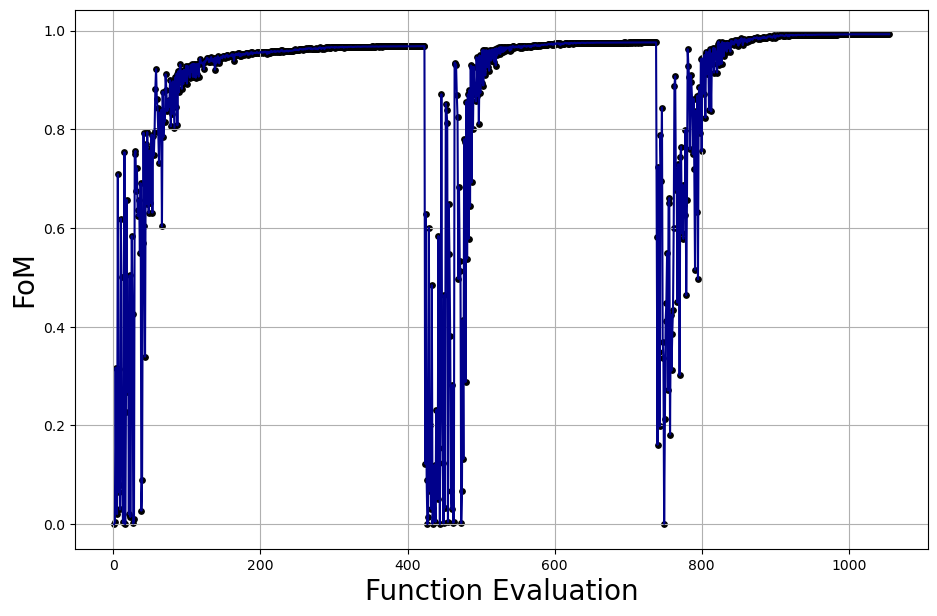

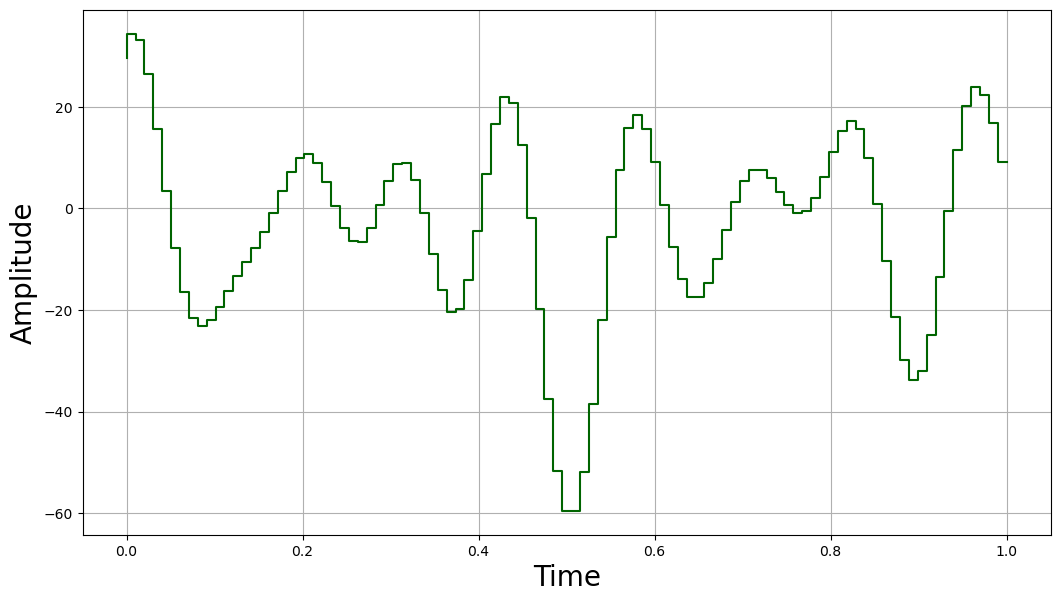

In [48]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]

# Plot the pulse over time
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkgreen', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)